In [1]:
# import basic packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import self-defined modules
from implementations import *
from tools import *
from helpers import *

# just to ingore warning
import warnings
warnings.filterwarnings('ignore')

# Models Training

## 1. Load Training Data

In [2]:
# load train and test data
data_path_tr = 'data/train.csv'
yb_tr, data_tr, idx_tr, labels = load_csv_data(data_path_tr, sub_sample=False)

# prepare the data using self-defined DataFrame class
labels_dataframe = ['Prediction'] + labels
data_tr_dataframe = np.concatenate((yb_tr.reshape([-1, 1]), data_tr), axis=1)
dataframe_tr = DataFrame(data_tr_dataframe, idx_tr.tolist(), labels_dataframe)

## 2. Data Analysis and Pre-processing

### 2.1 Replace Undefined Values in 'DER_mass_MMC'

In [3]:
# # calculate mode of 'DER_mass_MMC' in signal
# temp = dataframe_tr.loc(dataframe_tr['DER_mass_MMC']!=-999)
# temp = temp.loc(temp['Prediction']==1)
# DER_mode_s = temp.value_counts('DER_mass_MMC').index[0]

# # calculate mode of 'DER_mass_MMC' in background
# temp = dataframe_tr.loc(dataframe_tr['DER_mass_MMC']!=-999)
# temp = temp.loc(temp['Prediction']==-1)
# DER_mode_b = temp.value_counts('DER_mass_MMC').index[0]      

DER_mode_s =119.89
DER_mode_b =96.819

# replace -999（undefined values of 'DER_mass_MMC'） with mode respectively
temp = dataframe_tr.loc(dataframe_tr['DER_mass_MMC']==-999)
temp = temp.loc(temp['Prediction']==1)
dataframe_tr.loc(temp.index)['DER_mass_MMC'] = DER_mode_s

temp = dataframe_tr.loc(dataframe_tr['DER_mass_MMC']==-999)
temp = temp.loc(temp['Prediction']==-1)
dataframe_tr.loc(temp.index)['DER_mass_MMC'] = DER_mode_b

### 2.2 Drop features by histogram

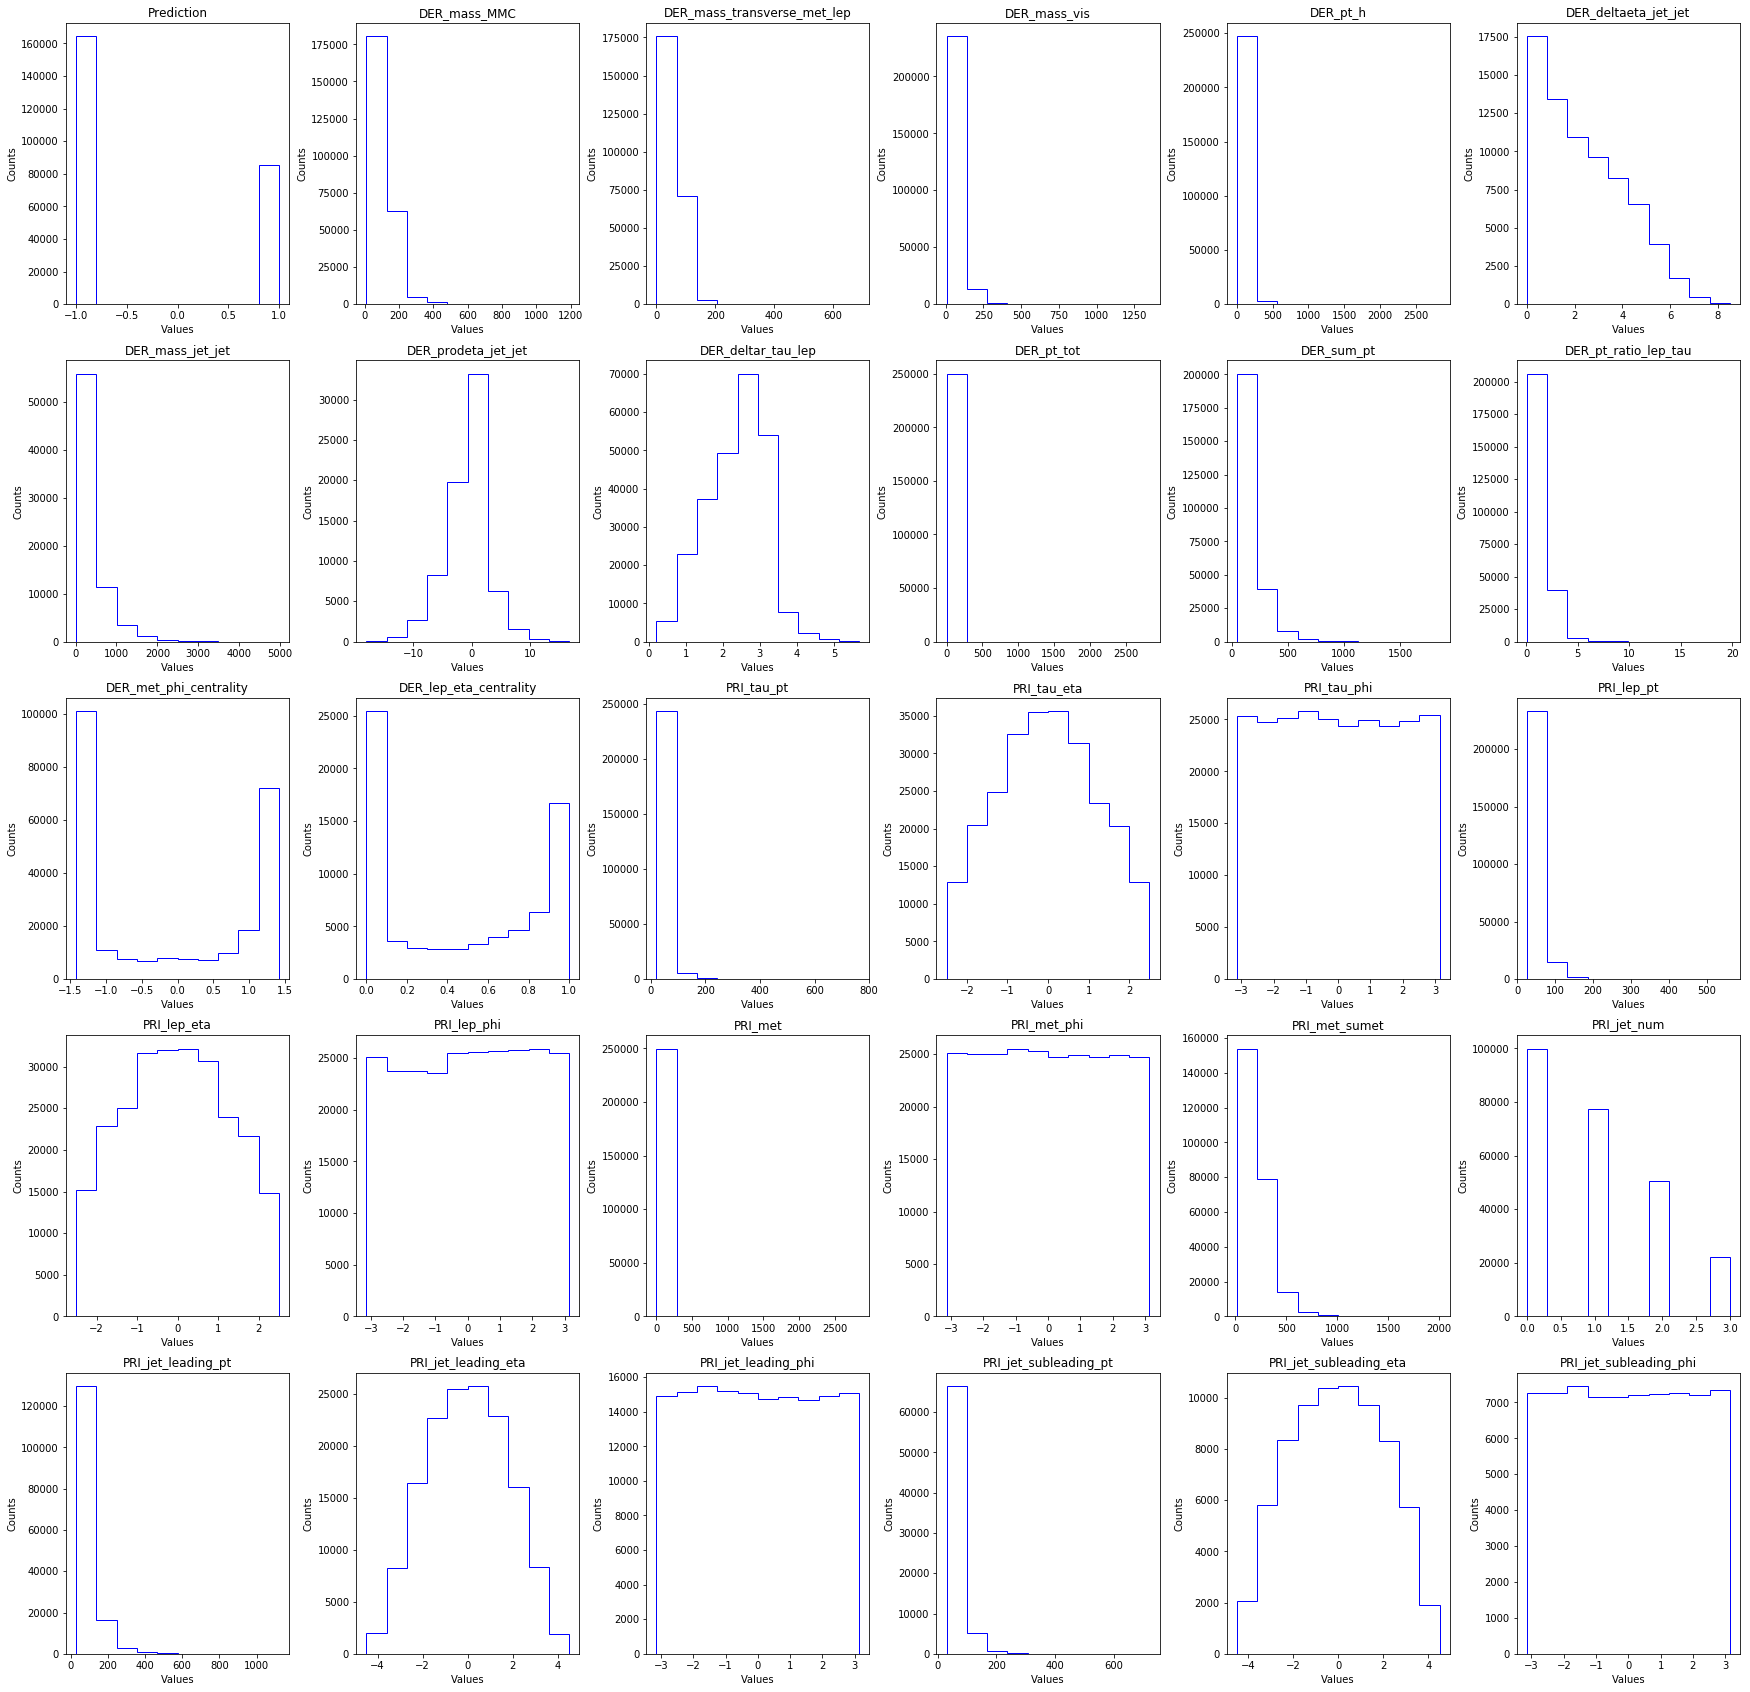

In [4]:
# plot histogram of each feature
figure, axes = plt.subplots(5, 6, facecolor='white', figsize=(30, 30))
figure.subplots_adjust(wspace=0.3)
axes = axes.ravel()

for index, axes_index in enumerate(axes):
    column = dataframe_tr.values[:, index]
    plot_data = column[np.where(column!=-999)]
    axes_index.hist(plot_data, histtype='step', color='b')
    axes_index.set_xlabel('Values')
    axes_index.set_ylabel('Counts')
    axes_index.set_title(dataframe_tr.labels[index])

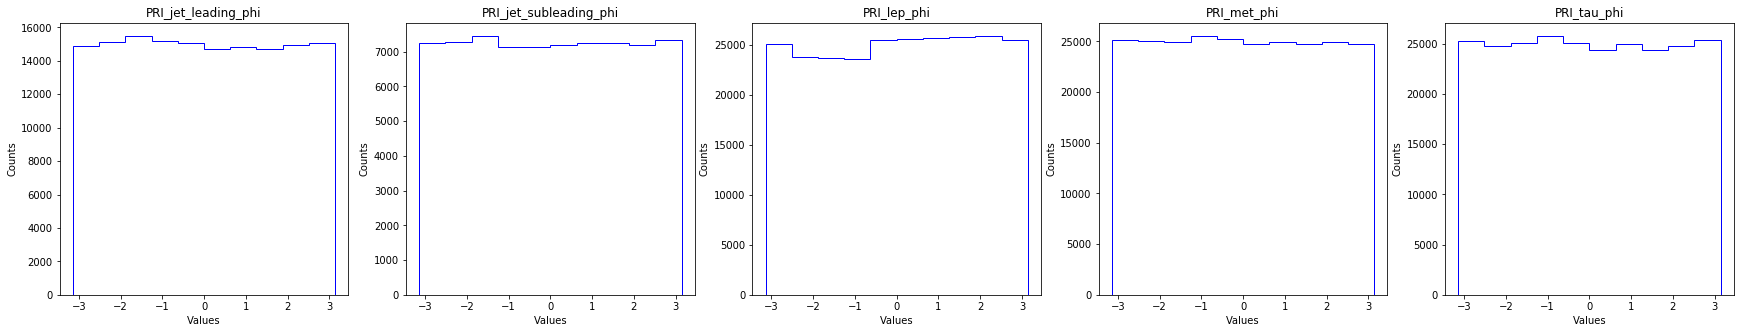

In [5]:
# drop features which are uniformly distributed
feature_dorp_phi = ['PRI_jet_leading_phi',
                    'PRI_jet_subleading_phi',
                    'PRI_lep_phi',
                    'PRI_met_phi',
                    'PRI_tau_phi']

figure, axes = plt.subplots(1, len(feature_dorp_phi), facecolor='white', figsize=(30, 5))
axes = axes.ravel()

for index, axes_index in enumerate(axes):
    column = dataframe_tr[feature_dorp_phi[index]]
    plot_data = column[np.where(column!=-999)]
    axes_index.hist(plot_data, histtype= 'step', color='b')
    axes_index.set_xlabel('Values')
    axes_index.set_ylabel('Counts')
    axes_index.set_title(feature_dorp_phi[index])

In [12]:
for index in range(5):
    figure, axes_index = plt.subplots(1, 1,figsize=(10, 8))
    column = dataframe_tr[feature_dorp_phi[index]]
    plot_data = column[np.where(column!=-999)]
    axes_index.hist(plot_data, histtype= 'step', color='b')
    axes_index.set_xlabel('Values')
    axes_index.set_ylabel('Counts')
    axes_index.set_title(feature_dorp_phi[index])
    plt.savefig(str(index) + '.jpg')
    del axes_index
    plt.close('all')

In [ ]:
dataframe_tr = dataframe_tr.drop(feature_dorp_phi)

### 2.3 Divide Training Data to 3 Groups

In [ ]:
# divide training data to 3 groups according to feature 'PRI_jet_num'
def group_features_by_jet(dataframe):
    return {  
        0: dataframe.loc( dataframe['PRI_jet_num'] == 0).copy(),
        1: dataframe.loc( dataframe['PRI_jet_num'] == 1).copy(),
        2: dataframe.loc((dataframe['PRI_jet_num'] == 2) | (dataframe['PRI_jet_num'] == 3)).copy(),
    }
dataframe_tr_grp = group_features_by_jet(dataframe_tr)
dataframe_tr_grp[0].values

### 2.4 Feature Selection

#### 2.4.1 Drop features with undefined values in each group

In [ ]:
# calculate missing rate 
def missing_rate(dataframe, miss_number):
    features = dataframe.drop(['Prediction'])
    missing_rate = []
    for feature in features.labels:
        data = features.loc(features[feature] ==  miss_number)
        if data.values.size != 0:
            missing_rate.append(data[feature].size / features[feature].size)
        else:
            missing_rate.append(0)
    missing_rate = np.array(missing_rate).reshape([1, -1]).squeeze()
    missing_rate_labels = dataframe.labels[1:]
    return DataFrame(missing_rate, [0], missing_rate_labels)

# get features with undefined values (features whose missing rate of -999 are 100%)
dataframe_tr_feature_undefined = []
for i in range(len(dataframe_tr_grp)):
    dataframe_tr_miss = missing_rate(dataframe_tr_grp[i], -999)
    dataframe_tr_feature_undefined.append(np.array(dataframe_tr_miss.labels)[dataframe_tr_miss.values == 1].tolist())

In [ ]:
# display those features with undefined values in each group
dataframe_tr_feature_undefined[0]

In [ ]:
dataframe_tr_feature_undefined[1]

In [ ]:
dataframe_tr_feature_undefined[2]

In [ ]:
# drop features with undefined values in each group
dataframe_tr_grp[0] = dataframe_tr_grp[0].drop(dataframe_tr_feature_undefined[0])
dataframe_tr_grp[1] = dataframe_tr_grp[1].drop(dataframe_tr_feature_undefined[1])
# group2 have no feature with undefined values

#### 2.4.2 Drop features with 0 values in each group

In [ ]:
# calculate zero rate
dataframe_tr_feature_zero = []
for i in range(len(dataframe_tr_grp)):
    dataframe_tr_miss = missing_rate(dataframe_tr_grp[i], 0)
    dataframe_tr_feature_zero.append(np.array(dataframe_tr_miss.labels)[dataframe_tr_miss.values == 1].tolist())
dataframe_tr_feature_zero

In [ ]:
# drop features with undefined values in each group
dataframe_tr_grp[0] = dataframe_tr_grp[0].drop(dataframe_tr_feature_zero[0])
dataframe_tr_grp[0].values

In [ ]:
# drop feature 'PRI_jet_num' which is already used for grouping
dataframe_tr_grp[1] = dataframe_tr_grp[1].drop('PRI_jet_num')
dataframe_tr_grp[2] = dataframe_tr_grp[2].drop('PRI_jet_num')

#### 2.4.3 Drop features with  strong linear correlation

In [ ]:
# calculate linear correlation coefficient matrix of each group
np.corrcoef(dataframe_tr_grp[0].values.T)

In [ ]:
def corr(self, threshold):
    corr = np.corrcoef(self.values.T)
    corr_list = []
    temp = np.array(self.labels)
    for i in range(corr.shape[0]):
        same_flag = []
        corr_coeff = temp[(corr[i] > threshold) | (corr[i] < -threshold)]
        corr_coeff = corr_coeff.tolist()
        if len(corr_coeff) > 1 and len(corr_list) != 0:
            for corr_term in corr_list:   # delete the same feature combinations
                judge_1 = (set(corr_term).intersection(set(corr_coeff)) == set(corr_term))
                judge_2 = (set(corr_term).intersection(set(corr_coeff)) == set(corr_coeff))
                same_flag.append(judge_1 | judge_2)
            if sum(same_flag) == 0:
                corr_list.append(corr_coeff)
        elif len(corr_coeff) > 1:
            corr_list.append(corr_coeff)
    return corr_list

# get feature combinations whose linear correlation coefficient larger than the threshold
threshold_tr = 0.7
corr_grp0 = corr(dataframe_tr_grp[0], threshold_tr)
corr_grp1 = corr(dataframe_tr_grp[1], threshold_tr)
corr_grp2 = corr(dataframe_tr_grp[2], threshold_tr)

In [ ]:
# display those feature combinations of each group 
corr_grp0

In [ ]:
corr_grp1

In [ ]:
corr_grp2

In [ ]:
# drop features with strong linear correlation
feature_dorp_corr0 = list(['DER_mass_MMC','DER_pt_tot','PRI_tau_pt','PRI_lep_pt'])
feature_dorp_corr1 = list(['DER_mass_MMC','DER_pt_h', 'DER_sum_pt', 'PRI_met_sumet','PRI_jet_all_pt','PRI_lep_pt'])
feature_dorp_corr2 = list(['DER_mass_MMC','DER_pt_h', 'DER_sum_pt', 'PRI_met_sumet','PRI_jet_all_pt','PRI_lep_pt'])

dataframe_tr_grp[0] = dataframe_tr_grp[0].drop(feature_dorp_corr0)
dataframe_tr_grp[1] = dataframe_tr_grp[1].drop(feature_dorp_corr1)
dataframe_tr_grp[2] = dataframe_tr_grp[2].drop(feature_dorp_corr2)

# Models Testing

In [ ]:
data_path_te = 'data/test.csv'
yb_te, data_te, idx_te, _ = load_csv_data(data_path_te, sub_sample=False)
data_te_dataframe = np.concatenate((yb_te.reshape([-1,1]), data_te), axis=1)
dataframe_te = DataFrame(data_te_dataframe, idx_tr.tolist(), labels_dataframe)

In [ ]:
# ridge_regression using crossv
w = []
acc_tr = []
acc_te = []
lambda_ = 0.0001
k_fold = 10
seed = 10

for i in range(len(dataframe_tr_grp)):
    x = dataframe_tr_grp[i].drop('Prediction').values
    x = log_process(x)
    x = build_polynomial_features(x,3)
    x_tr,_,_ = standardize(x)
    y_tr = (dataframe_tr_grp[i])['Prediction']
    w_tmp,acc_tr_tmp,acc_te_tmp = cv_loop(y_tr, x_tr,k_fold,seed,ridge_regression,lambda_=lambda_)
    w.append(w_tmp)
    acc_tr.append(acc_tr_tmp)
    acc_te.append(acc_te_tmp)

In [ ]:
acc_tr

In [20]:
x =np.arange(10,20)
y =np.arange(20,30)
train_idx = list(set(np.arange(10))-set([1,2]))
test_idx = [1,2]
[x_train, y_train, x_test, y_test] = [x[train_idx], y[train_idx], x[test_idx], y[test_idx]]
x_train  
#     loss, weight = regression_method(y=y_train, tx=x_train, **kwargs)
    
#     y_train_pred = predict_labels(weight, x_train)
#     y_test_pred = predict_labels(weight, x_test)

#     accuracy_train = compute_accuracy(y_train_pred, y_train)
#     accuracy_test = compute_accuracy(y_test_pred, y_test)

#     return weight, accuracy_train, accuracy_test

array([10, 13, 14, 15, 16, 17, 18, 19])

In [24]:
y_train

array([20, 23, 24, 25, 26, 27, 28, 29])

In [23]:
set(np.arange(10))-set([1,2])

{0, 3, 4, 5, 6, 7, 8, 9}

In [26]:
type(np.sqrt(4))

numpy.float64